In [1]:
# 경고창 무시
import warnings
warnings.filterwarnings('ignore')

## 피클 불러오기

In [2]:
jh_pickle = 'svc_best_model_jh.pkl'
sc_pickle = 'svc_best_model_sc.pkl'
mj_pickle = 'svc_best_model_mj.pkl'

import pickle
with open(jh_pickle,'rb') as pickle_file:
  jh_classification_model = pickle.load(pickle_file)
with open(sc_pickle,'rb') as pickle_file:
  sc_classification_model = pickle.load(pickle_file)
with open(mj_pickle,'rb') as pickle_file:
  mj_classification_model = pickle.load(pickle_file)

## 데이터 불러오기

In [3]:
import pandas as pd
import pymongo
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용
import scipy
import scipy.stats as stats
from konlpy.tag import Okt
okt = Okt()
from mecab import MeCab
mecab = MeCab()
import pyLDAvis
import pyLDAvis.lda_model
     
client=pymongo.MongoClient("192.168.10.240",27017)
db= client['AI_LKJ']
collection_tour = db['tour_contents']
collection_tour_train = db['data_tour_NLP_train']
data_tour = collection_tour.find()
data_tour_train = collection_tour_train.find()
df_tour = pd.DataFrame(data_tour)
df_tour_train = pd.DataFrame(data_tour_train)
df_tour

,_id,review_text,지역
0,65ee5e2b901db79521bc8779,[이벤트] 동트는 강원 취향저격 이벤트! 나에게 딱 맞는 강원 네이처 로드 코스는?,강원
1,65ee5e2b901db79521bc877a,봄 오는 소리 귀 기울이고 겨울 가는 아쉬움 녹이고,강원
2,65ee5e2c901db79521bc877b,하얀 이불 벗고 봄으로 가는 길 태평성대 가져온 봉황 눈앞에,강원
3,65ee5e2c901db79521bc877c,"열흘에 한 번, 고원 마을에 열리는 반짝 세일! 태백 통리장",강원
4,65ee5e2c901db79521bc877d,걸음 걸음 쌓이는 설렘 바다로 가는 오름길,강원
...,...,...,...
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주
49658,65ee9faac27eda916fc759b5,[윈터 바캉스] 10만원으로 떠나는 제주 당일치기,제주
49659,65ee9faac27eda916fc759b6,제주 서귀포층 패류 화석산지,제주
49660,65ee9faac27eda916fc759b7,제주 한림 용암동굴지대,제주


In [4]:
def split(text):
    clean_text = []
    for word in text.split():
        if "기자" not in word:
            clean_text.append(word)
    return " ".join(clean_text)

In [5]:
df_tour.loc[:,'review_text'] = df_tour['review_text'].apply(split)
# df_tour_train.query("review_text_clean.str.contains('사람')")[:50]
df_tour.query("review_text.str.contains('자단')")

,_id,review_text,지역


In [6]:
# 토크나이징 함수 정의
from konlpy.tag import Okt
okt = Okt()
stopwords = ['남해','대전','대전','공주','안동','나주','바퀴','보령','고령','신안','특산','공항','곡성','신상','사람','위치','가지','진도','장동','정리','도미','고창','모음','장성','시작','남원','가격','화순','국립','베스트','오토','레이스','후기','피아','중앙','공모전','태안','성주','봉화','남도','목포','군산','구례','순천','문경','완주','청주','청도','여수','울주군','포구','두기','거리','강진','뉴스','방법','통영','부여','한밭수목원','거제','서쪽','동쪽','양산','하동','포항','진주','우도','서귀포','당신', '대관령','속초','특별자치도', '삼척','영월','원주','화천','고성','양양','춘천','양구','철원','홍천','태백','달성군','구석구석','블로그','여행','여행지','경기','여주','서구','현황', '장생포','양평','가창','남평문씨','파주','영상','소개','지역','명소','요즘','마을','달성','한눈','카드','추천','수성','안산','기회','횡성','문진','발생','코스','현풍','문진','만끽']
def Tokenizer(raw, pos=["Noun"], stopword=stopwords):
    word_list = []
    for word, tag in okt.pos(raw,norm=True,stem=True):
        if len(word) > 1 and tag in pos and word not in stopword:
            if mecab.pos(word)[0][1] in ["NNG"]:
                if word == '화관':
                    word = '문화관'
                word_list.append(word)
    return " ".join(word_list)
    # return [
    #     word for word, tag in okt.pos(
    #         raw, 
    #         norm=True,   # normalize 그랰ㅋㅏ -> 그래ㅋㅋ
    #         stem=True    # stemming 바뀌나->바뀌다
    #         )
    #         if len(word) > 1 and tag in pos and word not in stopword 

    # ]

In [7]:
df_tour.loc[:,'review_text_clean']=df_tour['review_text'].apply(Tokenizer)

## 데이터 분류하기

In [8]:
df_tour_train

,_id,concept,season,review_text,지역,review_text_clean
0,65ee6316a64dee66ed301e2a,0,0,[블로그 울산 남구 아이스팩 전용 수거함 어디에 있을까?,울산,아이스팩 전용 수거
1,65ee670ba64dee66ed303175,5,3,[가을여행] 전주 당일치기 여행 BEST10 (feat. 덕진공원팸투어) /가을 단...,전북,가을 전주 당일치기 진공 투어 가을 단풍
2,65ee6a64c528b55b0ae79e58,4,0,"대전 유성구 관평동 맛집, 감동적인 맛과 가격 '매봉 쌀국수와 소바'",대전,맛집 감동 쌀국수
3,65ee60fc901db79521bc991b,3,0,역사를 따라가는 DMZ 로드,경기,역사 로드
4,65ee664fc528b55b0ae78d7a,5,0,"아브라다카브라라는 주문을 외워보고 싶은, '대전 보라매공원크리스마스 풍경'",대전,주문 보라매 공원 풍경
...,...,...,...,...,...,...
9995,65ee9b78c27eda916fc74ead,5,-,서귀포 추천 여행지 신창풍차해안도로,제주,풍차 해안 도로
9996,65ee66b6901db79521bcb1d6,4,-,"반려견과 함께 하는 커피 한 잔, 광주 애견동반카페 모음.ZIP",광주,반려견 커피 애견 동반
9997,65ee6722a64dee66ed3032ef,1,-,전북 문화공간 - 완주 복합문화지구 누에(Nu-e),전북,문화 공간 복합 문화 지구 누에
9998,65ee6cd5c528b55b0ae7a7b4,5,-,"벚꽃은 갔지만 유채꽃 만발, 서울에서 만나는 남해",서울,벚꽃 유채꽃 만발


In [9]:
df_tour_train.isnull().sum()

_id                    0
concept                0
season                 0
review_text            0
지역                     0
review_text_clean    225
dtype: int64

In [10]:
df_tour_train=df_tour_train.dropna()

In [11]:
df_tour_train.isnull().sum()

_id                  0
concept              0
season               0
review_text          0
지역                   0
review_text_clean    0
dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
df_tour_train_train,df_tour_train_test = train_test_split(df_tour_train,test_size=0.3,random_state=42)
df_tour_train['concept'].unique()

array([0, 5, 4, 3, 1, 2, 6])

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(tokenizer = Tokenizer, use_idf=True,max_df=0.95,min_df=2,ngram_range=(1,2))
tfidfVectorizer.fit(df_tour_train['review_text_clean'])

TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                tokenizer=<function Tokenizer at 0x7fb958313a60>)

In [14]:
train_feature = tfidfVectorizer.transform(df_tour_train_train['review_text_clean']) # train
train_target = df_tour_train_train['concept'] # test
test_feature = tfidfVectorizer.transform(df_tour_train_test['review_text_clean']) # train
test_target = df_tour_train_test['concept']


In [15]:
df_tour_train

,_id,concept,season,review_text,지역,review_text_clean
0,65ee6316a64dee66ed301e2a,0,0,[블로그 울산 남구 아이스팩 전용 수거함 어디에 있을까?,울산,아이스팩 전용 수거
1,65ee670ba64dee66ed303175,5,3,[가을여행] 전주 당일치기 여행 BEST10 (feat. 덕진공원팸투어) /가을 단...,전북,가을 전주 당일치기 진공 투어 가을 단풍
2,65ee6a64c528b55b0ae79e58,4,0,"대전 유성구 관평동 맛집, 감동적인 맛과 가격 '매봉 쌀국수와 소바'",대전,맛집 감동 쌀국수
3,65ee60fc901db79521bc991b,3,0,역사를 따라가는 DMZ 로드,경기,역사 로드
4,65ee664fc528b55b0ae78d7a,5,0,"아브라다카브라라는 주문을 외워보고 싶은, '대전 보라매공원크리스마스 풍경'",대전,주문 보라매 공원 풍경
...,...,...,...,...,...,...
9995,65ee9b78c27eda916fc74ead,5,-,서귀포 추천 여행지 신창풍차해안도로,제주,풍차 해안 도로
9996,65ee66b6901db79521bcb1d6,4,-,"반려견과 함께 하는 커피 한 잔, 광주 애견동반카페 모음.ZIP",광주,반려견 커피 애견 동반
9997,65ee6722a64dee66ed3032ef,1,-,전북 문화공간 - 완주 복합문화지구 누에(Nu-e),전북,문화 공간 복합 문화 지구 누에
9998,65ee6cd5c528b55b0ae7a7b4,5,-,"벚꽃은 갔지만 유채꽃 만발, 서울에서 만나는 남해",서울,벚꽃 유채꽃 만발


## Season 모델 작성
- season_RFC

In [16]:
df_tour_train.query("season != '-'")['season'].unique()

array([0, 3, 4, 1, 2], dtype=object)

In [17]:
df_tour_train_train.query("season != '-'")['review_text_clean']

655           캠핑 구산 해수욕장
178         엄마 학교 신입생 모집
3205      봉유 돼지 짬뽕 전복 짬뽕
800             기념물 이팝나무
92                항공샷 랜선
              ...       
2481         마다 평온 고이 시간
782      벚꽃 폴리스 공원 봄꽃 산책
1723         대비 면역 제철 음식
477     혈관 온라인 건강 캠페인 음식
878       외로움 간직 박물관 비양도
Name: review_text_clean, Length: 2727, dtype: object

In [18]:
season_train_feature = tfidfVectorizer.transform(df_tour_train_train.query("season != '-'")['review_text_clean']) # train
season_train_target = df_tour_train_train.query("season != '-'")['season'].astype('str') # test
season_train_feature_test = tfidfVectorizer.transform(df_tour_train_test.query("season != '-'")['review_text_clean']) # train
season_train_target_test = df_tour_train_test.query("season != '-'")['season'].astype('str') # test

In [19]:
from sklearn.ensemble import RandomForestClassifier
season_RFC=RandomForestClassifier(n_jobs=-1)
season_RFC.fit(season_train_feature,season_train_target)

RandomForestClassifier(n_jobs=-1)

In [20]:
from sklearn.metrics import accuracy_score
season_train_feature_predict = season_RFC.predict(season_train_feature)
accuracy_score(season_train_target, season_train_feature_predict)

0.9996332966629996

In [21]:
from sklearn.metrics import classification_report
print(classification_report(season_train_target, season_train_feature_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2273
           1       1.00      1.00      1.00       104
           2       1.00      0.99      1.00       103
           3       1.00      1.00      1.00       148
           4       1.00      1.00      1.00        99

    accuracy                           1.00      2727
   macro avg       1.00      1.00      1.00      2727
weighted avg       1.00      1.00      1.00      2727



In [22]:
season_test_feature_predict = season_RFC.predict(season_train_feature_test)
accuracy_score(season_train_target_test, season_test_feature_predict)

0.962089300758214

In [23]:
print(classification_report(season_train_target_test, season_test_feature_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       966
           1       1.00      0.76      0.86        41
           2       0.96      0.88      0.92        52
           3       0.93      0.85      0.89        81
           4       0.93      0.85      0.89        47

    accuracy                           0.96      1187
   macro avg       0.96      0.87      0.91      1187
weighted avg       0.96      0.96      0.96      1187



## Concept 모델 선택하기

### 주현

In [24]:
jh_train_feature = tfidfVectorizer.transform(df_tour_train_train['review_text_clean']) # train
jh_train_target = df_tour_train_train['concept'] # test
jh_test_feature = tfidfVectorizer.transform(df_tour_train_test['review_text_clean']) # train
jh_test_target = df_tour_train_test['concept']


In [25]:
jh_classification_model.fit(jh_train_feature,jh_train_target)

SVC(C=1, degree=2, gamma=0.1, kernel='linear')

In [26]:
jh_train_feature_predict = jh_classification_model.predict(jh_train_feature)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(jh_train_target,jh_train_feature_predict))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1945
           1       0.90      0.84      0.87      1656
           2       0.95      0.78      0.86       195
           3       0.89      0.76      0.82       325
           4       0.96      0.89      0.92       593
           5       0.89      0.90      0.89      1832
           6       0.84      0.71      0.77       296

    accuracy                           0.87      6842
   macro avg       0.89      0.83      0.86      6842
weighted avg       0.88      0.87      0.87      6842



In [28]:
jh_test_feature_predict = jh_classification_model.predict(jh_test_feature)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(jh_test_target,jh_test_feature_predict))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       833
           1       0.80      0.72      0.76       729
           2       0.87      0.55      0.67        73
           3       0.79      0.55      0.65       138
           4       0.89      0.75      0.81       232
           5       0.78      0.83      0.80       793
           6       0.70      0.53      0.60       135

    accuracy                           0.77      2933
   macro avg       0.79      0.68      0.72      2933
weighted avg       0.77      0.77      0.76      2933



### 명준

### 석천

In [30]:
sc_train_feature = tfidfVectorizer.transform(df_tour_train_train['review_text_clean']) # train
sc_train_target = df_tour_train_train['concept'] # test
sc_test_feature = tfidfVectorizer.transform(df_tour_train_test['review_text_clean']) # train
sc_test_target = df_tour_train_test['concept']

In [31]:
sc_classification_model.fit(sc_train_feature,sc_train_target)

SVC()

In [32]:
sc_train_feature_predict = sc_classification_model.predict(sc_train_feature)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(sc_train_target,sc_train_feature_predict))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1945
           1       0.95      0.94      0.94      1656
           2       0.99      0.86      0.92       195
           3       0.95      0.86      0.90       325
           4       0.98      0.95      0.97       593
           5       0.95      0.96      0.95      1832
           6       0.95      0.79      0.86       296

    accuracy                           0.94      6842
   macro avg       0.95      0.90      0.93      6842
weighted avg       0.94      0.94      0.94      6842



In [34]:
sc_test_feature_predict = sc_classification_model.predict(sc_test_feature)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(sc_test_target,sc_test_feature_predict))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       833
           1       0.80      0.72      0.76       729
           2       0.92      0.48      0.63        73
           3       0.82      0.48      0.61       138
           4       0.91      0.69      0.78       232
           5       0.79      0.82      0.80       793
           6       0.75      0.45      0.56       135

    accuracy                           0.76      2933
   macro avg       0.81      0.65      0.70      2933
weighted avg       0.77      0.76      0.76      2933



## 데이터

In [36]:
df_tour

,_id,review_text,지역,review_text_clean
0,65ee5e2b901db79521bc8779,[이벤트] 동트는 강원 취향저격 이벤트! 나에게 딱 맞는 강원 네이처 로드 코스는?,강원,이벤트 취향 저격 이벤트 로드
1,65ee5e2b901db79521bc877a,봄 오는 소리 귀 기울이고 겨울 가는 아쉬움 녹이고,강원,소리 겨울 아쉬움
2,65ee5e2c901db79521bc877b,하얀 이불 벗고 봄으로 가는 길 태평성대 가져온 봉황 눈앞에,강원,이불 태평성대 봉황 눈앞
3,65ee5e2c901db79521bc877c,"열흘에 한 번, 고원 마을에 열리는 반짝 세일! 태백 통리장",강원,열흘 통리
4,65ee5e2c901db79521bc877d,걸음 걸음 쌓이는 설렘 바다로 가는 오름길,강원,걸음 걸음 바다로
...,...,...,...,...
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주,전국 맛집
49658,65ee9faac27eda916fc759b5,[윈터 바캉스] 10만원으로 떠나는 제주 당일치기,제주,바캉스 당일치기
49659,65ee9faac27eda916fc759b6,제주 서귀포층 패류 화석산지,제주,패류 화석 산지
49660,65ee9faac27eda916fc759b7,제주 한림 용암동굴지대,제주,한림 용암동굴 지대


In [37]:
## 컨셉

# 벡터라이징
jh_feature = tfidfVectorizer.transform(df_tour['review_text_clean'])


# 컨셉 예측을 모델 학습
tour_concept_predict = jh_classification_model.predict(jh_feature)
# 예측한값을 concept 컬럼에 추가
df_tour.loc[:,'concept']=tour_concept_predict
# concept열을 jh_target이라고 정의
jh_target_concept = df_tour['concept']
# 모델 학습
jh_classification_model.fit(jh_feature,jh_target_concept)

SVC(C=1, degree=2, gamma=0.1, kernel='linear')

In [38]:
## 계절

# 컨셉 예측을 모델 학습
tour_season_predict = season_RFC.predict(jh_feature)
# 예측한값을 
df_tour.loc[:,'season']=tour_season_predict
# concept열을 jh_target이라고 정의
jh_target_season = df_tour['season']
# 모델 학습
season_RFC.fit(jh_feature,jh_target_season)

RandomForestClassifier(n_jobs=-1)

In [39]:
df_tour

,_id,review_text,지역,review_text_clean,concept,season
0,65ee5e2b901db79521bc8779,[이벤트] 동트는 강원 취향저격 이벤트! 나에게 딱 맞는 강원 네이처 로드 코스는?,강원,이벤트 취향 저격 이벤트 로드,0,0
1,65ee5e2b901db79521bc877a,봄 오는 소리 귀 기울이고 겨울 가는 아쉬움 녹이고,강원,소리 겨울 아쉬움,0,4
2,65ee5e2c901db79521bc877b,하얀 이불 벗고 봄으로 가는 길 태평성대 가져온 봉황 눈앞에,강원,이불 태평성대 봉황 눈앞,0,0
3,65ee5e2c901db79521bc877c,"열흘에 한 번, 고원 마을에 열리는 반짝 세일! 태백 통리장",강원,열흘 통리,0,0
4,65ee5e2c901db79521bc877d,걸음 걸음 쌓이는 설렘 바다로 가는 오름길,강원,걸음 걸음 바다로,0,0
...,...,...,...,...,...,...
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주,전국 맛집,4,0
49658,65ee9faac27eda916fc759b5,[윈터 바캉스] 10만원으로 떠나는 제주 당일치기,제주,바캉스 당일치기,0,0
49659,65ee9faac27eda916fc759b6,제주 서귀포층 패류 화석산지,제주,패류 화석 산지,0,0
49660,65ee9faac27eda916fc759b7,제주 한림 용암동굴지대,제주,한림 용암동굴 지대,5,0


## 데이터 탐색

In [40]:
# 값이 0인값들이 결측값이 아닌 유의미한 value로 인식되는 듯함.

df_tour.isnull().sum()

_id                  0
review_text          0
지역                   0
review_text_clean    0
concept              0
season               0
dtype: int64

In [41]:
# condition collection

concept_nothing = "concept == 0"
concept_culture = "concept == 1"
concept_leisure = "concept == 2"
concept_history = "concept == 3"
concept_food = "concept == 4"
concept_nature = "concept == 5"
concept_healing = "concept == 6"

season_nothing = "season == 0"
season_spring = "season == 1"
season_summer = "season == 2"
season_autumn = "season == 3"
season_winter = "season == 4"

In [42]:
df_tour_concept = df_tour[df_tour["concept"] != 0]

In [43]:
df_tour["season"]=df_tour["season"].astype('int')

In [44]:
df_tour_season = df_tour[df_tour["season"] != 0]

In [45]:
df_tour_concept

,_id,review_text,지역,review_text_clean,concept,season
7,65ee5e2c901db79521bc8780,"와인에 스민 청정자연, 향에 반하고 풍광에 취한다",강원,와인 청정 자연 취한,5,0
9,65ee5e2c901db79521bc8782,하늘에 뿌린 눈꽃 천상의 설원 되다,강원,하늘 눈꽃 천상 설원,5,0
11,65ee5e2d901db79521bc8784,"자연과 인공의 조화, 절벽 위에 핀 누정",강원,자연 인공 조화 절벽 누정,5,0
21,65ee5e2e901db79521bc878e,겨울 강원도여행 대관령 삼양라운드힐 설경 눈구경 가볼만한곳 삼양목장,강원,겨울 설경 구경 목장,5,4
23,65ee5e2e901db79521bc8790,강원도 겨울 축제 홍천 평창 화천 가볼만한곳 얼음 낚시 체험 가볼만한곳,강원,겨울 축제 얼음 낚시 체험,1,4
...,...,...,...,...,...,...
49651,65ee9fa7c27eda916fc759ae,정방폭포 제주도 가볼만한 곳 제주여행,제주,정방폭포,5,0
49652,65ee9fa7c27eda916fc759af,[제주맛집] 먹방! 제주쇠소깍 오메기식당,제주,맛집 먹방 식당,4,0
49654,65ee9fa8c27eda916fc759b1,제주시 오라동 유채꽃밭 (오라동 메밀꽃밭),제주,유채꽃 메밀 꽃밭,5,1
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주,전국 맛집,4,0


In [46]:
# concept 를 텍스트화 
df_tour_concept['concept_name'] = df_tour_concept['concept'].map({1: '문화', 2: '레져', 3: '역사', 4: '음식',  5: '자연',  6: '힐링'})
df_tour_concept

,_id,review_text,지역,review_text_clean,concept,season,concept_name
7,65ee5e2c901db79521bc8780,"와인에 스민 청정자연, 향에 반하고 풍광에 취한다",강원,와인 청정 자연 취한,5,0,자연
9,65ee5e2c901db79521bc8782,하늘에 뿌린 눈꽃 천상의 설원 되다,강원,하늘 눈꽃 천상 설원,5,0,자연
11,65ee5e2d901db79521bc8784,"자연과 인공의 조화, 절벽 위에 핀 누정",강원,자연 인공 조화 절벽 누정,5,0,자연
21,65ee5e2e901db79521bc878e,겨울 강원도여행 대관령 삼양라운드힐 설경 눈구경 가볼만한곳 삼양목장,강원,겨울 설경 구경 목장,5,4,자연
23,65ee5e2e901db79521bc8790,강원도 겨울 축제 홍천 평창 화천 가볼만한곳 얼음 낚시 체험 가볼만한곳,강원,겨울 축제 얼음 낚시 체험,1,4,문화
...,...,...,...,...,...,...,...
49651,65ee9fa7c27eda916fc759ae,정방폭포 제주도 가볼만한 곳 제주여행,제주,정방폭포,5,0,자연
49652,65ee9fa7c27eda916fc759af,[제주맛집] 먹방! 제주쇠소깍 오메기식당,제주,맛집 먹방 식당,4,0,음식
49654,65ee9fa8c27eda916fc759b1,제주시 오라동 유채꽃밭 (오라동 메밀꽃밭),제주,유채꽃 메밀 꽃밭,5,1,자연
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주,전국 맛집,4,0,음식


In [47]:
# season 을 텍스트화
df_tour_season['season_name'] = df_tour_season['season'].map({1: '봄', 2: '여름', 3: '가을', 4: '겨울'})
df_tour_season

,_id,review_text,지역,review_text_clean,concept,season,season_name
1,65ee5e2b901db79521bc877a,봄 오는 소리 귀 기울이고 겨울 가는 아쉬움 녹이고,강원,소리 겨울 아쉬움,0,4,겨울
5,65ee5e2c901db79521bc877e,겨울이 지나 봄이 올 때 강릉 나들이 다녀오기,강원,겨울,0,4,겨울
13,65ee5e2d901db79521bc8786,"딱 열흘간 열리는 겨울왕국, 영원히 남을 순백의 추억",강원,열흘 겨울왕국 순백 추억,0,4,겨울
18,65ee5e2d901db79521bc878b,국내 여행지 추천 강원도 1박2일 여행코스 겨울 속초 가볼만한곳,강원,국내 겨울,0,4,겨울
19,65ee5e2e901db79521bc878c,겨울이 선사한 은빛 무대 마음껏 춤을 춰봐,강원,겨울 선사 은빛 무대,0,4,겨울
...,...,...,...,...,...,...,...
49613,65ee9f9ac27eda916fc75988,여름휴가 시원한 제주도 여행지 모음 여기는 꼭 가봐야해 !,제주,여름 휴가,6,2,여름
49619,65ee9f9cc27eda916fc7598e,제주도 여름휴가 시원한 맥주 마시기 좋은 표선맛집 저녁먹기에도 GooD,제주,여름 휴가 맥주 표선 맛집 저녁,4,2,여름
49628,65ee9f9fc27eda916fc75997,성수기 제주도여행 여름휴가때 꼭 먹어봐야할 자연산 다금바리 맛집,제주,수기 여름 휴가 자연 다금바리 맛집,5,2,여름
49634,65ee9fa1c27eda916fc7599d,"제주도여행 해수욕장 및 드라이브 그리고 제주도 수국, 해바라기 동영상",제주,해수욕장 드라이브 수국 해바라기 동영상,5,2,여름


## 데이터 분석

### 1. 여행 유형별 빈도수
- 접근 : 어떤 유형의 키워드가 많을지 파악
- 결과 : 자연 > 문화 > 음식 > 힐링 > 역사 > 레져

In [48]:
value_culture = df_tour_concept.query("concept_name == '문화'").value_counts().sum()
value_leisure = df_tour_concept.query("concept_name == '레져'").value_counts().sum()
value_history = df_tour_concept.query("concept_name == '역사'").value_counts().sum()
value_food = df_tour_concept.query("concept_name == '음식'").value_counts().sum()
value_nature = df_tour_concept.query("concept_name == '자연'").value_counts().sum()
value_healing = df_tour_concept.query("concept_name == '힐링'").value_counts().sum()

In [49]:
df_value_concept = pd.DataFrame({'concept_name': ['문화', '레져', '역사', '음식', '자연', '힐링'],'value': [value_culture, value_leisure, value_history, value_food, value_nature, value_healing]})
df_value_concept

,concept_name,value
0,문화,10973
1,레져,922
2,역사,1759
3,음식,3490
4,자연,13190
5,힐링,1775


<Axes: xlabel='concept_name', ylabel='value'>

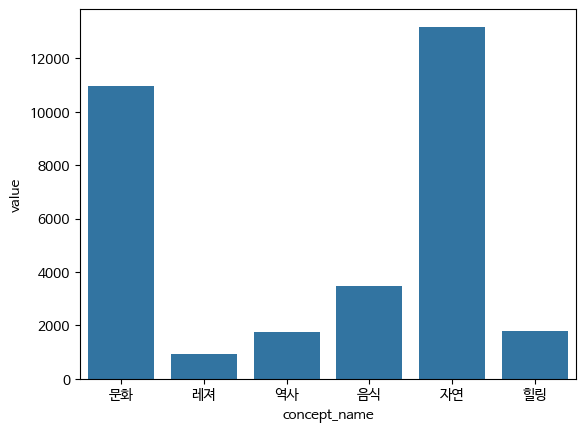

In [50]:
sns.barplot(data=df_value_concept , x = "concept_name", y = "value")

### 2. 지역별
- 접근 1 : 지역별 키워드 빈도수
- 접근 2 : 지역별 여행 유형 빈도수
- 접근 3 : 지역별 계절 빈도수

#### (1) 접근 1 : 지역별 키워드 빈도수
- 결과(top3) : 제주 > 대전 > 울산

In [51]:
df_region = pd.DataFrame(df_tour_concept["지역"].value_counts())
df_region

,count
지역,
제주,4983
대전,4603
울산,3669
대구,3035
경북,2120
충남,1717
강원,1670
경남,1657
전남,1571


<Axes: xlabel='지역', ylabel='count'>

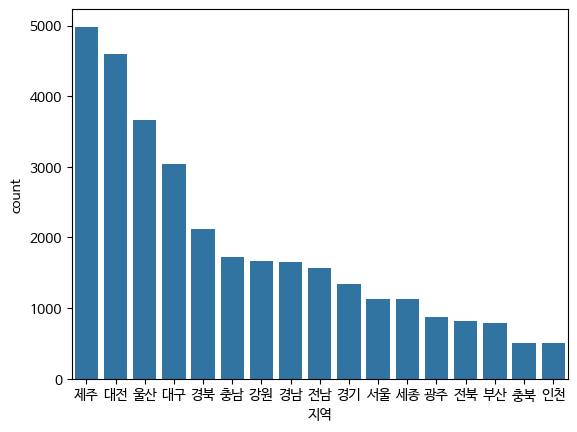

In [52]:
sns.barplot(data = df_region , x="지역", y="count")

#### (2) 접근 2 : 지역별 여행 유형 빈도수
- 결과
  + 제주 : 자연 > 문화 > 음식 > 힐링 > 역사 > 레져
  + 대전 : 자연 > 문화 > 음식 > 힐링 > 역사 > 레져
  + 울산 : 문화 > 자연 > 음식 > 역사 > 힐링 > 레져
  + 대구 : 문화 > 자연 > 음식 > 힐링 > 역사 > 레져
  + 경북 : 자연 > 문화 > 역사 > 힐링 > 음식 > 레져
  + 충남 : 자연 > 문화 > 힐링 > 역사 > 음식 > 레져
  + 강원 : 자연 > 문화 > 음식 > 힐링 > 역사 > 레져
  + 경남 : 자연 > 문화 > 역사 > 힐링 > 음식 > 레져
  + 전남 : 자연 > 문화 > 음식 > 힐링 > 역사 > 레져
  + 경기 : 문화 > 자연 > 역사 > 힐링 > 음식 > 레져
  + 서울 : 문화 > 자연 > 음식 > 역사 > 힐링 > 레져
  + 세종 : 자연 > 문화 > 역사 > 레져 > 힐링 > 음식
  + 광주 : 자연 > 문화 > 음식 > 힐링 > 역사 > 레져
  + 전북 : 자연 > 문화 > 역사 > 힐링 > 레져 > 음식
  + 부산 : 자연 > 문화 > 음식 > 역사 > 힐링 > 레져
  + 충북 : 자연 > 문화 > 음식 > 힐링 > 역사 > 레져
  + 인천 : 자연 > 문화 > 음식 > 힐링 > 레져 > 역사

<Axes: xlabel='concept_name', ylabel='count'>

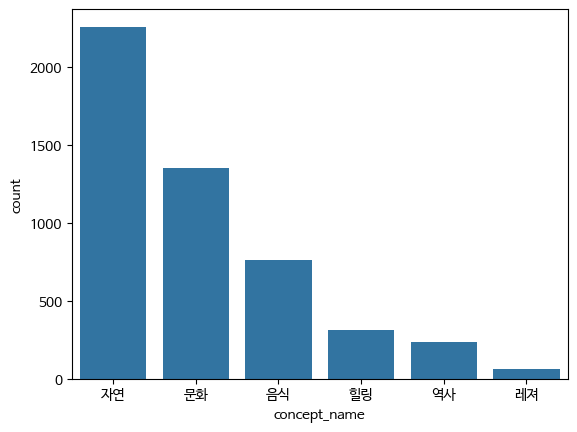

In [53]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='제주'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

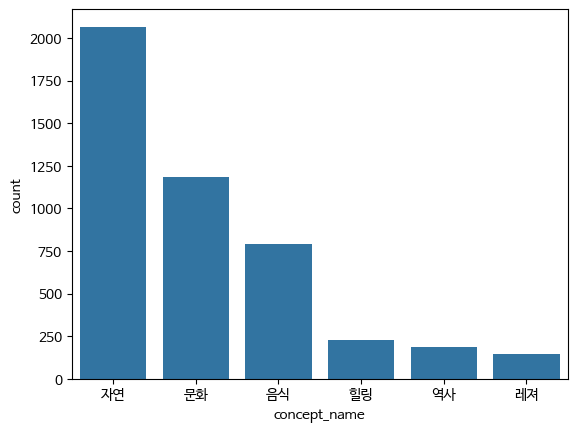

In [54]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='대전'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

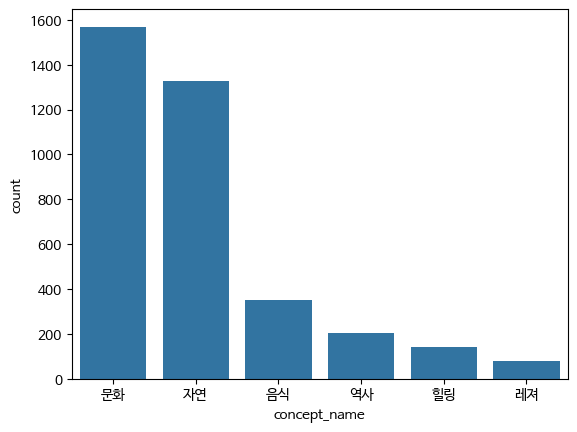

In [55]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='울산'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

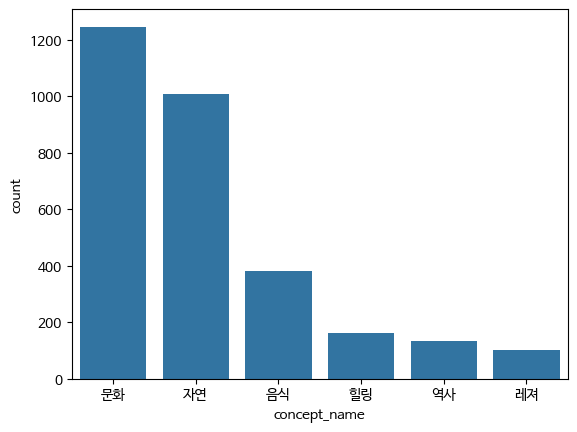

In [56]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='대구'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

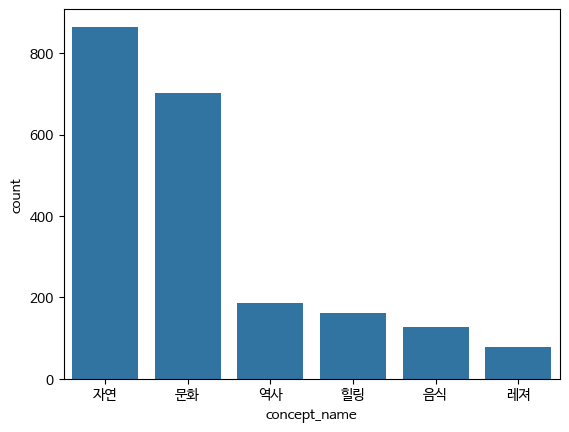

In [57]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='경북'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

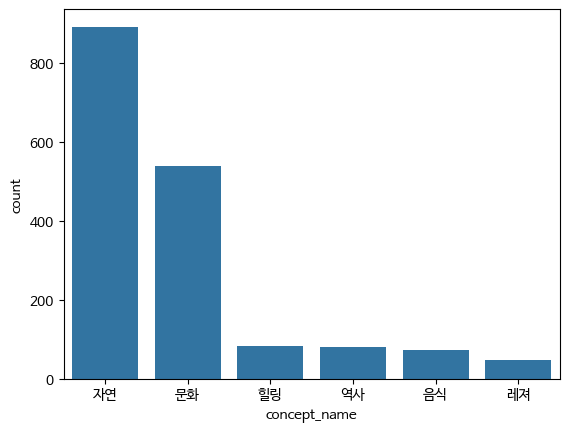

In [58]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='충남'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

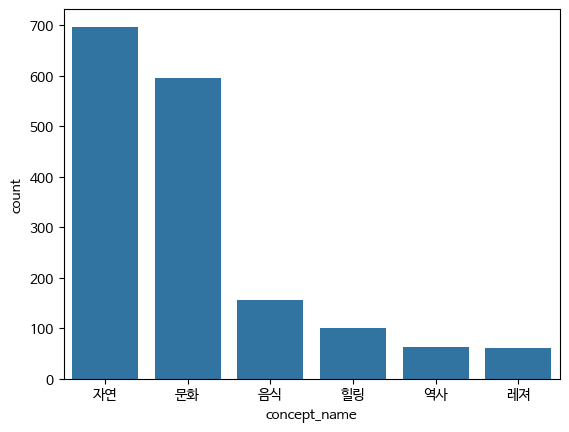

In [59]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='강원'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

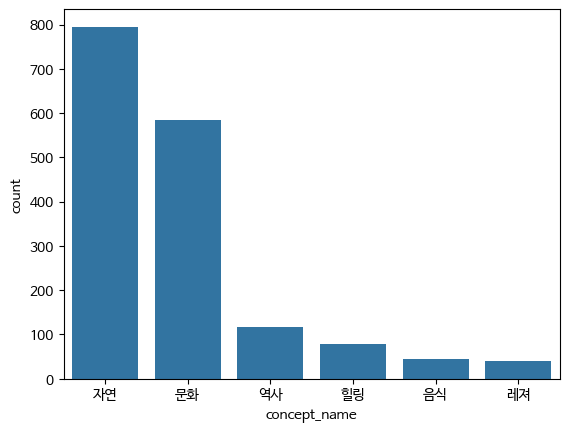

In [60]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='경남'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

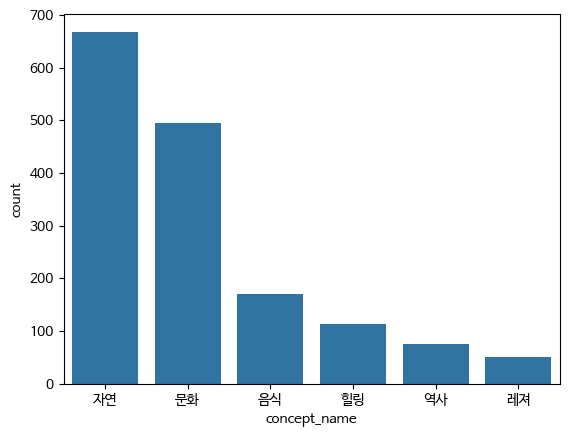

In [61]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='전남'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

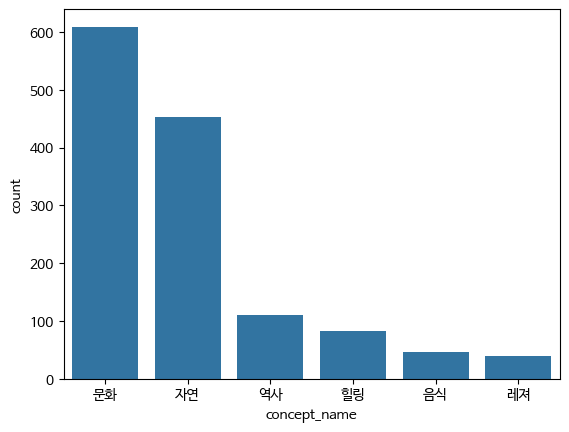

In [62]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='경기'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

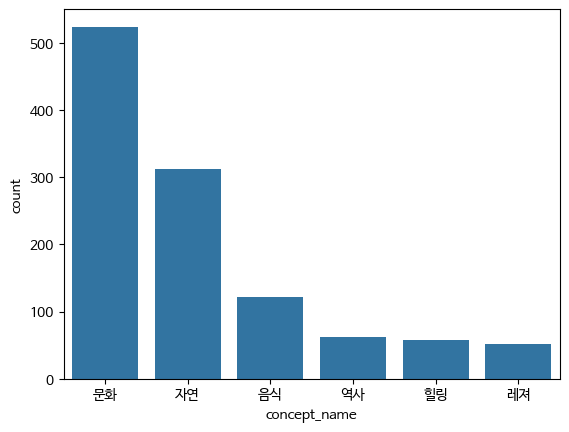

In [63]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='서울'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

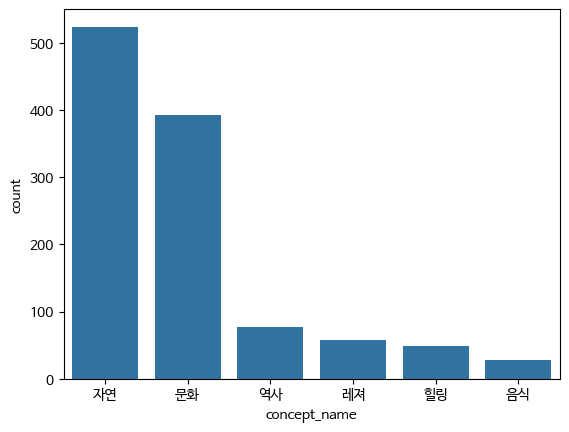

In [64]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='세종'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

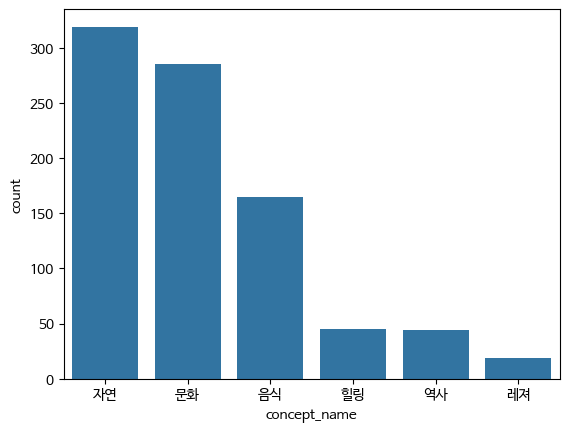

In [65]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='광주'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

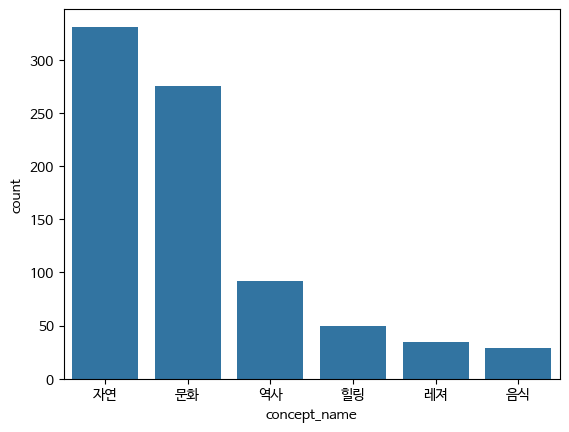

In [66]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='전북'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

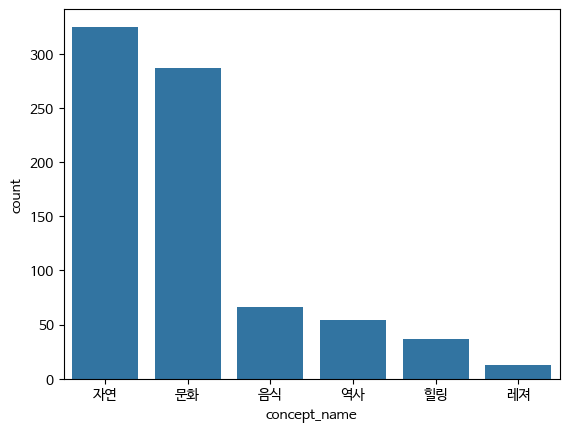

In [67]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='부산'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

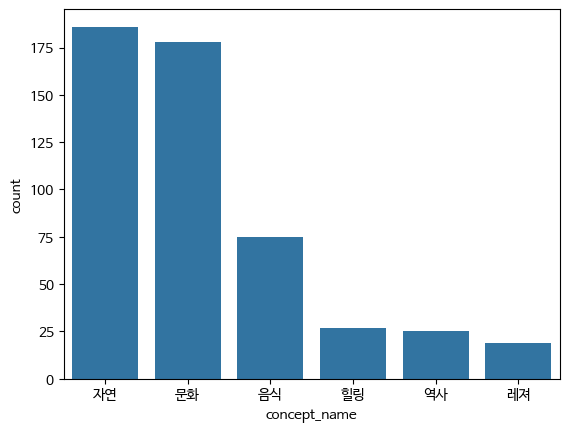

In [68]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='충북'")["concept_name"].value_counts()), x="concept_name",y="count")

<Axes: xlabel='concept_name', ylabel='count'>

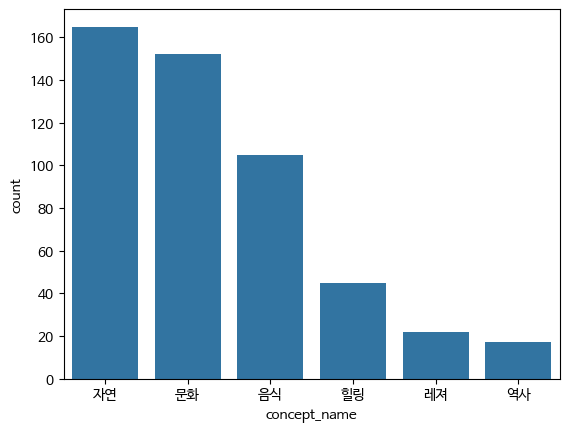

In [69]:
sns.barplot(data=pd.DataFrame(df_tour_concept.query("지역=='인천'")["concept_name"].value_counts()), x="concept_name",y="count")

#### (3) 접근 3 : 지역별 계절 빈도수
- 결과
  + 제주 : 가을 > 봄 > 여름 > 겨울
  + 대전 : 가을 > 봄 > 겨울 > 여름
  + 울산 : 가을 > 봄 > 여름 > 겨울
  + 대구 : 가을 > 겨울 > 봄 > 여름
  + 경북 : 가을 > 여름 > 봄 > 겨울
  + 충남 : 가을 > 겨울 > 봄 > 여름
  + 강원 : 겨울 > 가을 > 여름 > 봄
  + 경남 : 가을 > 봄 > 여름 > 겨울
  + 전남 : 가을 > 겨울 > 여름 > 봄
  + 경기 : 가을 > 봄 > 겨울 > 여름
  + 서울 : 가을 > 봄 > 겨울 > 여름
  + 세종 : 가을 > 봄 > 겨울 > 여름
  + 광주 : 가을 > 봄 > 여름 > 겨울
  + 전북 : 가을 > 겨울 > 여름 > 봄
  + 부산 : 가을 > 봄 > 여름 > 겨울
  + 충북 : 가을 > 겨울 > 봄 > 여름
  + 인천 : 가을 > 겨울 > 여름 > 봄

<Axes: xlabel='season_name', ylabel='count'>

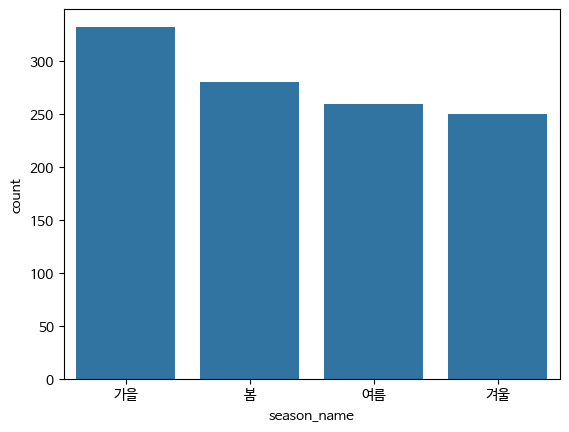

In [70]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='제주'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

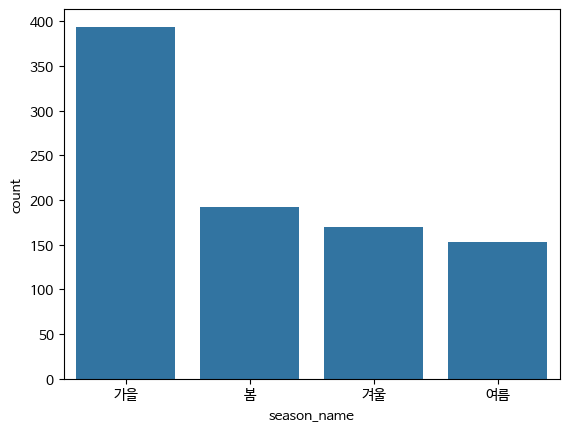

In [71]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='대전'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

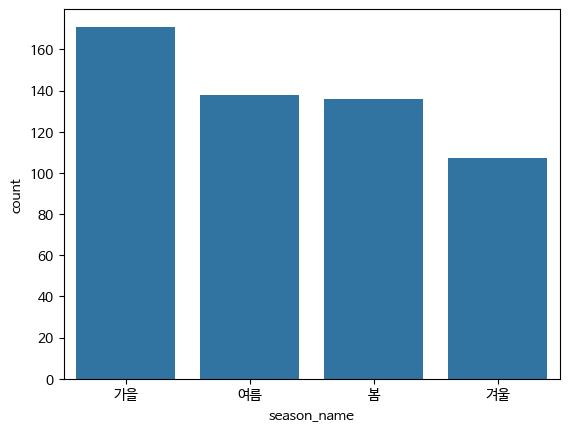

In [72]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='울산'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

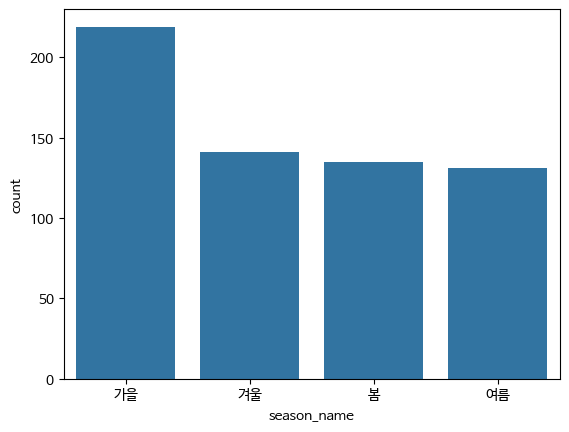

In [73]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='대구'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

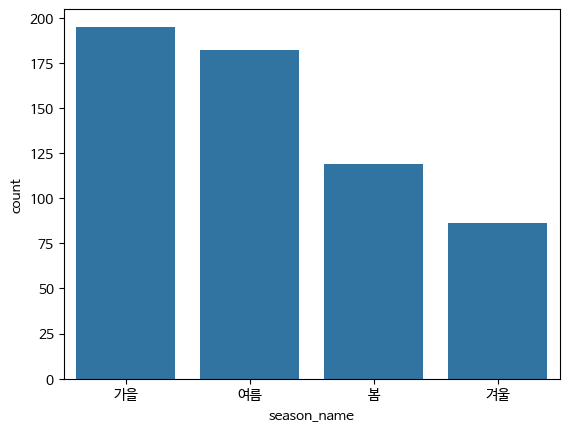

In [74]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='경북'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

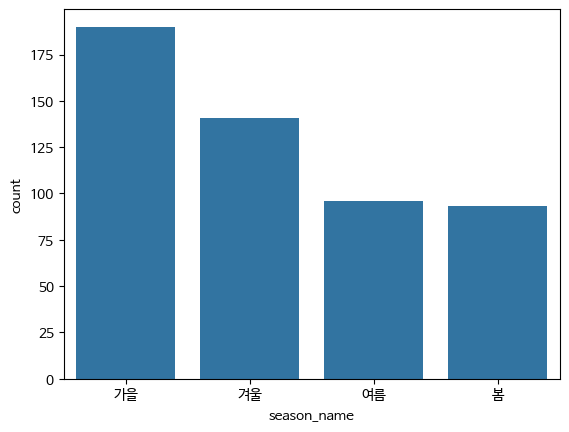

In [75]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='충남'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

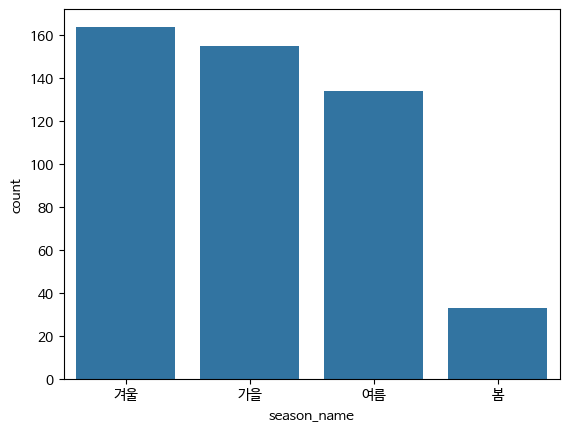

In [76]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='강원'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

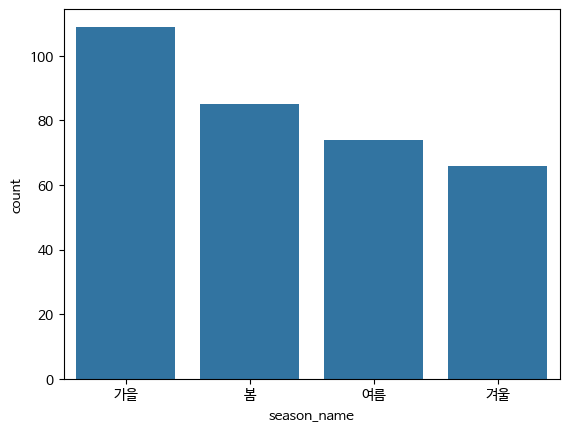

In [77]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='경남'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

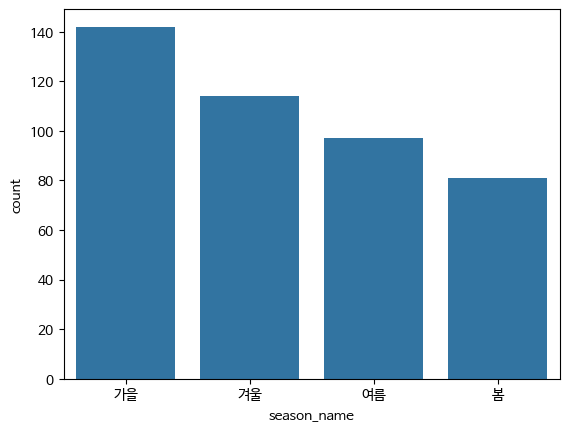

In [78]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='전남'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

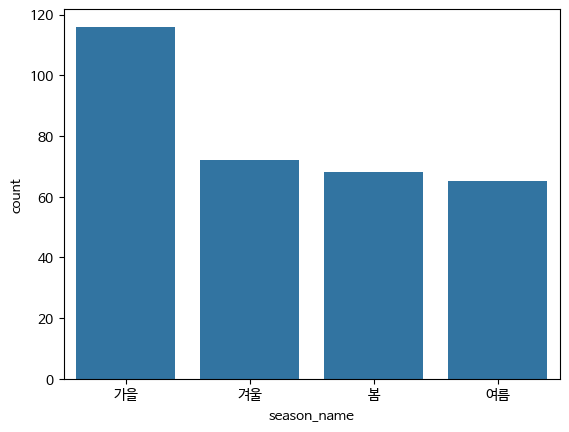

In [79]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='경기'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

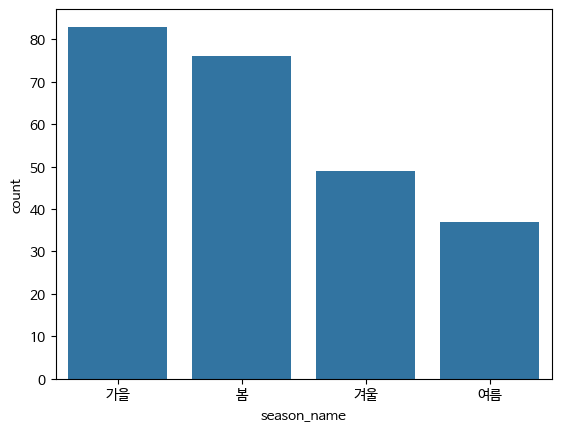

In [80]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='서울'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

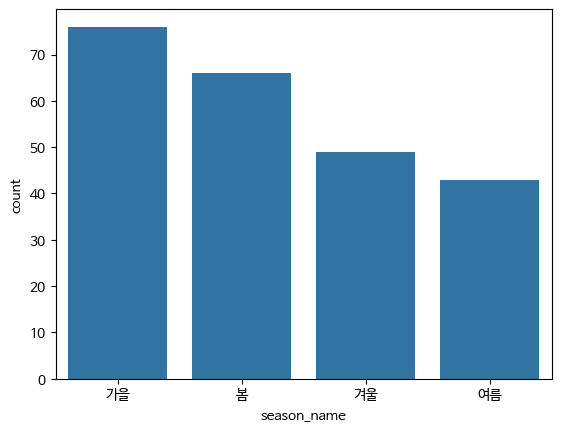

In [81]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='세종'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

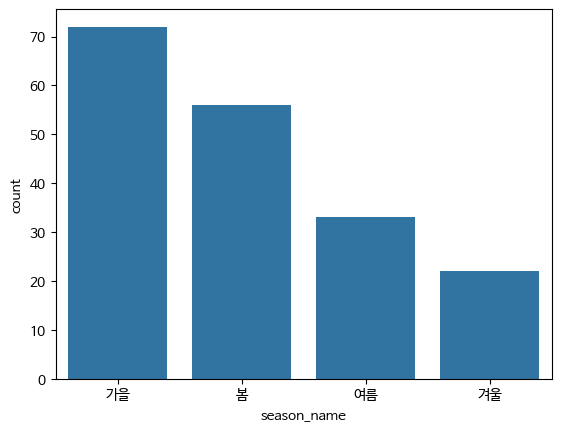

In [82]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='광주'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

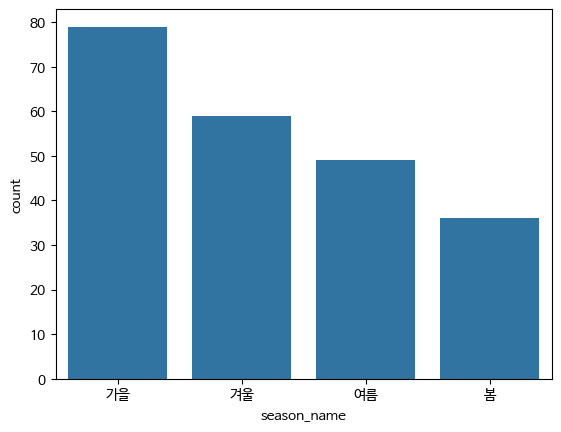

In [83]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='전북'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

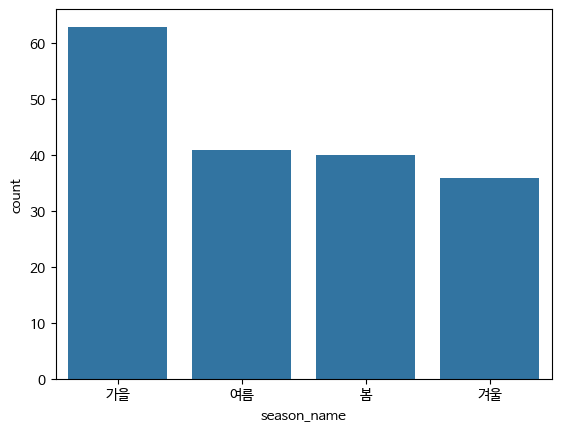

In [84]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='부산'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

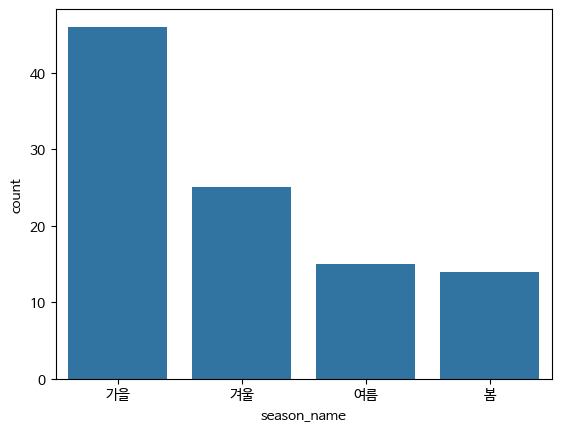

In [85]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='충북'")["season_name"].value_counts()), x="season_name",y="count")

<Axes: xlabel='season_name', ylabel='count'>

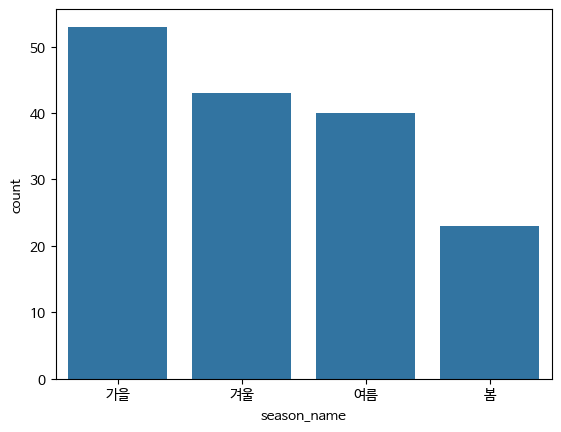

In [86]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("지역=='인천'")["season_name"].value_counts()), x="season_name",y="count")

### 3. 계절별
- 접근 1 : 계절별 지역 빈도수
- 접근 2 : 계절별 여행 유형 빈도수

#### (1) 접근 1 : 계절별로 지역빈도수
- 결과(Top3)
  + 봄 : 제주,대전,울산
  + 여름 : 제주,경북,대전
  + 가을 : 대전,제주,대구
  + 겨울 : 제주,대전,강원

<Axes: xlabel='지역', ylabel='count'>

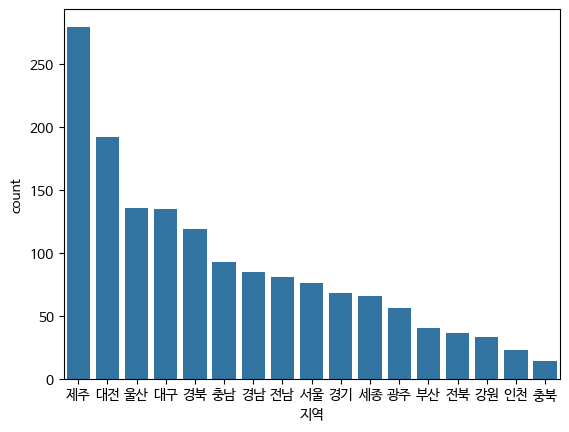

In [87]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("season_name=='봄'")["지역"].value_counts()), x="지역",y="count")

<Axes: xlabel='지역', ylabel='count'>

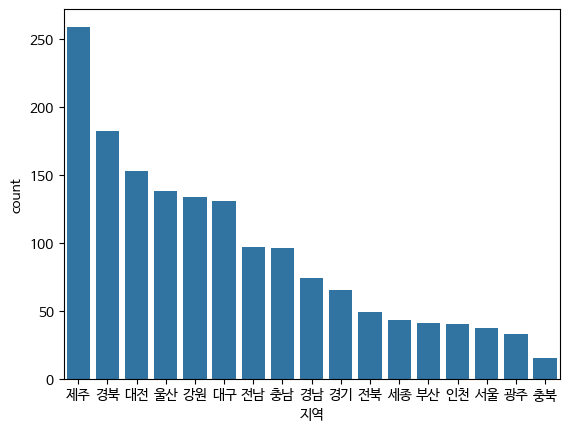

In [88]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("season_name=='여름'")["지역"].value_counts()), x="지역",y="count")

<Axes: xlabel='지역', ylabel='count'>

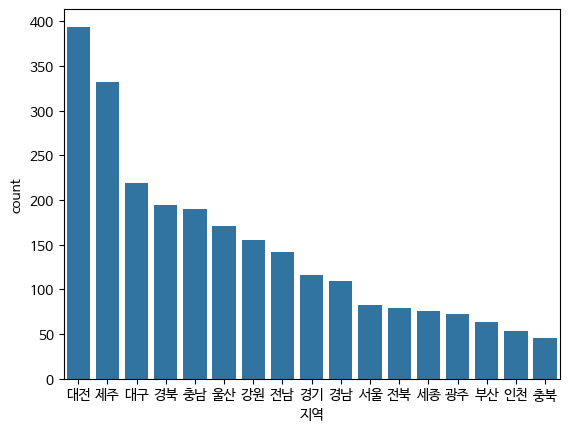

In [89]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("season_name=='가을'")["지역"].value_counts()), x="지역",y="count")

<Axes: xlabel='지역', ylabel='count'>

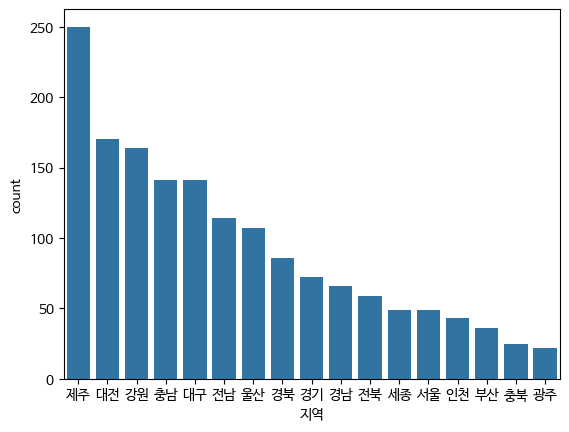

In [90]:
sns.barplot(data=pd.DataFrame(df_tour_season.query("season_name=='겨울'")["지역"].value_counts()), x="지역",y="count")

#### (2) 접근 2 : 계절별 여행 유형 빈도수
- 접근 : 어떤 계절에 어떤 유형의 키워드가 많은지를 파악

##### (1) 봄
- 결과 : 자연 > 문화 > 힐링 > 레져 > 음식 > 역사

In [91]:
spring_culture = df_tour_season.query("season_name == '봄'").query("concept == 1").value_counts().sum()
spring_leisure = df_tour_season.query("season_name == '봄'").query("concept == 2").value_counts().sum()
spring_history = df_tour_season.query("season_name == '봄'").query("concept == 3").value_counts().sum()
spring_food = df_tour_season.query("season_name == '봄'").query("concept == 4").value_counts().sum()
spring_nature = df_tour_season.query("season_name == '봄'").query("concept == 5").value_counts().sum()
spring_healing = df_tour_season.query("season_name == '봄'").query("concept == 6").value_counts().sum()

In [92]:
df_spring = pd.DataFrame({'concept' : ["문화","레져","역사","음식","자연","힐링"], 'value': [spring_culture,spring_leisure,spring_history,spring_food,spring_nature,spring_healing]})
df_spring

,concept,value
0,문화,168
1,레져,29
2,역사,19
3,음식,28
4,자연,1170
5,힐링,39


<Axes: xlabel='concept', ylabel='value'>

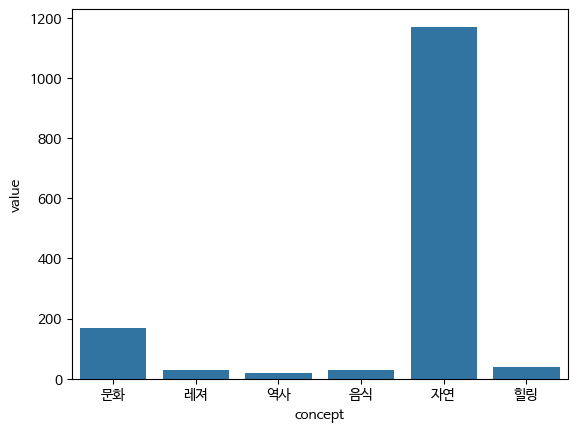

In [93]:
sns.barplot(data=df_spring, x="concept", y="value")

##### (2) 여름
- 결과 : 자연 > 문화 > 힐링 > 음식 > 레져 > 역사

In [94]:
summer_culture = df_tour_season.query("season_name == '여름'").query("concept == 1").value_counts().sum()
summer_leisure = df_tour_season.query("season_name == '여름'").query("concept == 2").value_counts().sum()
summer_history = df_tour_season.query("season_name == '여름'").query("concept == 3").value_counts().sum()
summer_food = df_tour_season.query("season_name == '여름'").query("concept == 4").value_counts().sum()
summer_nature = df_tour_season.query("season_name == '여름'").query("concept == 5").value_counts().sum()
summer_healing = df_tour_season.query("season_name == '여름'").query("concept == 6").value_counts().sum()

In [95]:
df_summer = pd.DataFrame({'concept' : ["문화","레져","역사","음식","자연","힐링"], 'value': [summer_culture,summer_leisure,summer_history,summer_food,summer_nature,summer_healing]})
df_summer

,concept,value
0,문화,255
1,레져,42
2,역사,19
3,음식,84
4,자연,599
5,힐링,117


<Axes: xlabel='concept', ylabel='value'>

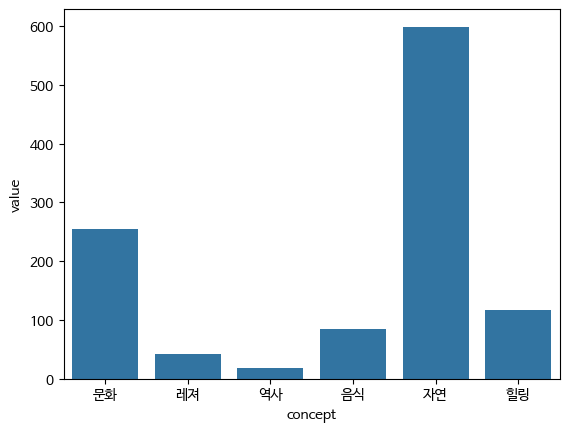

In [96]:
sns.barplot(data=df_summer, x="concept", y="value")

##### (3) 가을
- 결과 : 자연 > 문화 > 힐링 > 레져 > 음식 > 역사

In [97]:
autumn_culture = df_tour_season.query("season_name == '가을'").query("concept == 1").value_counts().sum()
autumn_leisure = df_tour_season.query("season_name == '가을'").query("concept == 2").value_counts().sum()
autumn_history = df_tour_season.query("season_name == '가을'").query("concept == 3").value_counts().sum()
autumn_food = df_tour_season.query("season_name == '가을'").query("concept == 4").value_counts().sum()
autumn_nature = df_tour_season.query("season_name == '가을'").query("concept == 5").value_counts().sum()
autumn_healing = df_tour_season.query("season_name == '가을'").query("concept == 6").value_counts().sum()

In [98]:
df_autumn = pd.DataFrame({'concept' : ["문화","레져","역사","음식","자연","힐링"], 'value': [autumn_culture,autumn_leisure,autumn_history,autumn_food,autumn_nature,autumn_healing]})
df_autumn

,concept,value
0,문화,313
1,레져,82
2,역사,18
3,음식,52
4,자연,1314
5,힐링,124


<Axes: xlabel='concept', ylabel='value'>

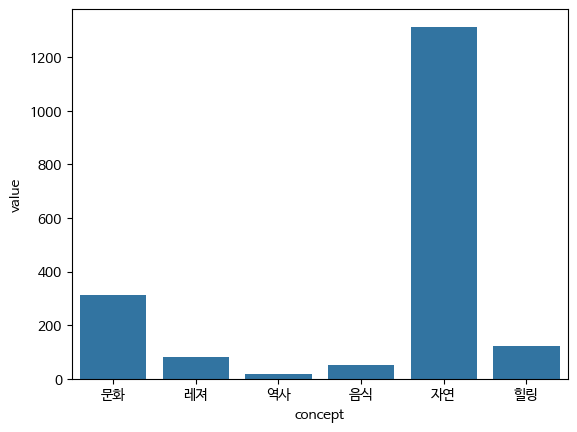

In [99]:
sns.barplot(data=df_autumn, x="concept", y="value")

##### (4) 겨울
- 결과 : 자연 > 문화 > 음식 > 힐링 > 레져	 > 역사

In [100]:
winter_culture = df_tour_season.query("season_name == '겨울'").query("concept == 1").value_counts().sum()
winter_leisure = df_tour_season.query("season_name == '겨울'").query("concept == 2").value_counts().sum()
winter_history = df_tour_season.query("season_name == '겨울'").query("concept == 3").value_counts().sum()
winter_food = df_tour_season.query("season_name == '겨울'").query("concept == 4").value_counts().sum()
winter_nature = df_tour_season.query("season_name == '겨울'").query("concept == 5").value_counts().sum()
winter_healing = df_tour_season.query("season_name == '겨울'").query("concept == 6").value_counts().sum()

In [101]:
df_winter = pd.DataFrame({'concept' : ["문화","레져","역사","음식","자연","힐링"], 'value': [winter_culture,winter_leisure,winter_history,winter_food,winter_nature,winter_healing]})
df_winter

,concept,value
0,문화,336
1,레져,38
2,역사,23
3,음식,89
4,자연,578
5,힐링,48


<Axes: xlabel='concept', ylabel='value'>

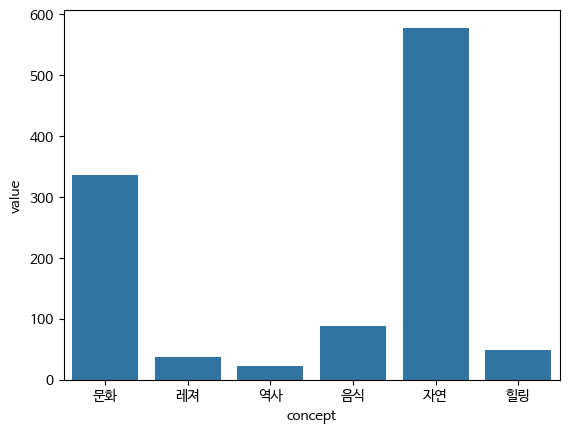

In [102]:
sns.barplot(data=df_winter, x="concept", y="value")

### 4. 유형별
- 접근 1 : 유형별 지역 빈도수
- 접근 2 : 유형별 계졀 빈도수

#### (1) 접근 1 : 유형별 지역 빈도수
- 결과(top3)
  + 자연 : 제주, 대전, 울산
  + 문화 : 울산, 제주, 대구
  + 레져 : 대전, 대구, 울산 
  + 역사 : 제주, 울산, 대전
  + 음식 : 대전, 제주, 대구
  + 힐링 : 제주, 대전, 대구

In [103]:
# 자연
nature_1 = df_tour_concept.query("concept_name == '자연'").query("지역 =='제주'").value_counts().sum()
nature_2 = df_tour_concept.query("concept_name == '자연'").query("지역 =='대전'").value_counts().sum()
nature_3 = df_tour_concept.query("concept_name == '자연'").query("지역 =='울산'").value_counts().sum()
nature_4 = df_tour_concept.query("concept_name == '자연'").query("지역 =='대구'").value_counts().sum()
nature_5 = df_tour_concept.query("concept_name == '자연'").query("지역 =='충남'").value_counts().sum()
nature_6 = df_tour_concept.query("concept_name == '자연'").query("지역 =='경북'").value_counts().sum()
nature_7 = df_tour_concept.query("concept_name == '자연'").query("지역 =='경남'").value_counts().sum()
nature_8 = df_tour_concept.query("concept_name == '자연'").query("지역 =='강원'").value_counts().sum()
nature_9 = df_tour_concept.query("concept_name == '자연'").query("지역 =='전남'").value_counts().sum()
nature_10 = df_tour_concept.query("concept_name == '자연'").query("지역 =='세종'").value_counts().sum()
nature_11 = df_tour_concept.query("concept_name == '자연'").query("지역 =='경기'").value_counts().sum()
nature_12 = df_tour_concept.query("concept_name == '자연'").query("지역 =='전북'").value_counts().sum()
nature_13 = df_tour_concept.query("concept_name == '자연'").query("지역 =='부산'").value_counts().sum()
nature_14 = df_tour_concept.query("concept_name == '자연'").query("지역 =='광주'").value_counts().sum()
nature_15 = df_tour_concept.query("concept_name == '자연'").query("지역 =='서울'").value_counts().sum()
nature_16 = df_tour_concept.query("concept_name == '자연'").query("지역 =='충북'").value_counts().sum()
nature_17 = df_tour_concept.query("concept_name == '자연'").query("지역 =='인천'").value_counts().sum()

df_nature = pd.DataFrame({'지역' : ["제주","대전","울산","대구","충남","경북","경남","강원","전남","세종","경기","전북","부산","광주","서울","충북","인천"], 'value': [nature_1,nature_2,nature_3,nature_4,nature_5,nature_6,nature_7,nature_8,nature_9,nature_10,nature_11,nature_12,nature_13,nature_14,nature_15,nature_16,nature_17]})
df_nature

,지역,value
0,제주,2257
1,대전,2066
2,울산,1325
3,대구,1010
4,충남,892
5,경북,865
6,경남,795
7,강원,697
8,전남,668
9,세종,524


In [104]:
# 문화
culture_1 = df_tour_concept.query("concept_name == '문화'").query("지역 =='제주'").value_counts().sum()
culture_2 = df_tour_concept.query("concept_name == '문화'").query("지역 =='대전'").value_counts().sum()
culture_3 = df_tour_concept.query("concept_name == '문화'").query("지역 =='울산'").value_counts().sum()
culture_4 = df_tour_concept.query("concept_name == '문화'").query("지역 =='대구'").value_counts().sum()
culture_5 = df_tour_concept.query("concept_name == '문화'").query("지역 =='충남'").value_counts().sum()
culture_6 = df_tour_concept.query("concept_name == '문화'").query("지역 =='경북'").value_counts().sum()
culture_7 = df_tour_concept.query("concept_name == '문화'").query("지역 =='경남'").value_counts().sum()
culture_8 = df_tour_concept.query("concept_name == '문화'").query("지역 =='강원'").value_counts().sum()
culture_9 = df_tour_concept.query("concept_name == '문화'").query("지역 =='전남'").value_counts().sum()
culture_10 = df_tour_concept.query("concept_name == '문화'").query("지역 =='세종'").value_counts().sum()
culture_11 = df_tour_concept.query("concept_name == '문화'").query("지역 =='경기'").value_counts().sum()
culture_12 = df_tour_concept.query("concept_name == '문화'").query("지역 =='전북'").value_counts().sum()
culture_13 = df_tour_concept.query("concept_name == '문화'").query("지역 =='부산'").value_counts().sum()
culture_14 = df_tour_concept.query("concept_name == '문화'").query("지역 =='광주'").value_counts().sum()
culture_15 = df_tour_concept.query("concept_name == '문화'").query("지역 =='서울'").value_counts().sum()
culture_16 = df_tour_concept.query("concept_name == '문화'").query("지역 =='충북'").value_counts().sum()
culture_17 = df_tour_concept.query("concept_name == '문화'").query("지역 =='인천'").value_counts().sum()

df_culture = pd.DataFrame({'지역' : ["제주","대전","울산","대구","충남","경북","경남","강원","전남","세종","경기","전북","부산","광주","서울","충북","인천"], 'value': [culture_1,culture_2,culture_3,culture_4,culture_5,culture_6,culture_7,culture_8,culture_9,culture_10,culture_11,culture_12,culture_13,culture_14,culture_15,culture_16,culture_17]})
df_culture

,지역,value
0,제주,1354
1,대전,1185
2,울산,1569
3,대구,1247
4,충남,540
5,경북,703
6,경남,584
7,강원,595
8,전남,494
9,세종,392


In [105]:
# 레져
leisure_1 = df_tour_concept.query("concept_name == '레져'").query("지역 =='제주'").value_counts().sum()
leisure_2 = df_tour_concept.query("concept_name == '레져'").query("지역 =='대전'").value_counts().sum()
leisure_3 = df_tour_concept.query("concept_name == '레져'").query("지역 =='울산'").value_counts().sum()
leisure_4 = df_tour_concept.query("concept_name == '레져'").query("지역 =='대구'").value_counts().sum()
leisure_5 = df_tour_concept.query("concept_name == '레져'").query("지역 =='충남'").value_counts().sum()
leisure_6 = df_tour_concept.query("concept_name == '레져'").query("지역 =='경북'").value_counts().sum()
leisure_7 = df_tour_concept.query("concept_name == '레져'").query("지역 =='경남'").value_counts().sum()
leisure_8 = df_tour_concept.query("concept_name == '레져'").query("지역 =='강원'").value_counts().sum()
leisure_9 = df_tour_concept.query("concept_name == '레져'").query("지역 =='전남'").value_counts().sum()
leisure_10 = df_tour_concept.query("concept_name == '레져'").query("지역 =='세종'").value_counts().sum()
leisure_11 = df_tour_concept.query("concept_name == '레져'").query("지역 =='경기'").value_counts().sum()
leisure_12 = df_tour_concept.query("concept_name == '레져'").query("지역 =='전북'").value_counts().sum()
leisure_13 = df_tour_concept.query("concept_name == '레져'").query("지역 =='부산'").value_counts().sum()
leisure_14 = df_tour_concept.query("concept_name == '레져'").query("지역 =='광주'").value_counts().sum()
leisure_15 = df_tour_concept.query("concept_name == '레져'").query("지역 =='서울'").value_counts().sum()
leisure_16 = df_tour_concept.query("concept_name == '레져'").query("지역 =='충북'").value_counts().sum()
leisure_17 = df_tour_concept.query("concept_name == '레져'").query("지역 =='인천'").value_counts().sum()

df_leisure = pd.DataFrame({'지역' : ["제주","대전","울산","대구","충남","경북","경남","강원","전남","세종","경기","전북","부산","광주","서울","충북","인천"], 'value': [leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,leisure_13,leisure_14,leisure_15,leisure_16,leisure_17]})
df_leisure

,지역,value
0,제주,65
1,대전,143
2,울산,81
3,대구,100
4,충남,48
5,경북,79
6,경남,39
7,강원,60
8,전남,50
9,세종,58


In [106]:
# 역사
history_1 = df_tour_concept.query("concept_name == '역사'").query("지역 =='제주'").value_counts().sum()
history_2 = df_tour_concept.query("concept_name == '역사'").query("지역 =='대전'").value_counts().sum()
history_3 = df_tour_concept.query("concept_name == '역사'").query("지역 =='울산'").value_counts().sum()
history_4 = df_tour_concept.query("concept_name == '역사'").query("지역 =='대구'").value_counts().sum()
history_5 = df_tour_concept.query("concept_name == '역사'").query("지역 =='충남'").value_counts().sum()
history_6 = df_tour_concept.query("concept_name == '역사'").query("지역 =='경북'").value_counts().sum()
history_7 = df_tour_concept.query("concept_name == '역사'").query("지역 =='경남'").value_counts().sum()
history_8 = df_tour_concept.query("concept_name == '역사'").query("지역 =='강원'").value_counts().sum()
history_9 = df_tour_concept.query("concept_name == '역사'").query("지역 =='전남'").value_counts().sum()
history_10 = df_tour_concept.query("concept_name == '역사'").query("지역 =='세종'").value_counts().sum()
history_11 = df_tour_concept.query("concept_name == '역사'").query("지역 =='경기'").value_counts().sum()
history_12 = df_tour_concept.query("concept_name == '역사'").query("지역 =='전북'").value_counts().sum()
history_13 = df_tour_concept.query("concept_name == '역사'").query("지역 =='부산'").value_counts().sum()
history_14 = df_tour_concept.query("concept_name == '역사'").query("지역 =='광주'").value_counts().sum()
history_15 = df_tour_concept.query("concept_name == '역사'").query("지역 =='서울'").value_counts().sum()
history_16 = df_tour_concept.query("concept_name == '역사'").query("지역 =='충북'").value_counts().sum()
history_17 = df_tour_concept.query("concept_name == '역사'").query("지역 =='인천'").value_counts().sum()

df_history = pd.DataFrame({'지역' : ["제주","대전","울산","대구","충남","경북","경남","강원","전남","세종","경기","전북","부산","광주","서울","충북","인천"], 'value': [history_1,history_2,history_3,history_4,history_5,history_6,history_7,history_8,history_9,history_10,history_11,history_12,history_13,history_14,history_15,history_16,history_17]})
df_history

,지역,value
0,제주,236
1,대전,187
2,울산,202
3,대구,134
4,충남,81
5,경북,185
6,경남,116
7,강원,62
8,전남,75
9,세종,77


In [107]:
# 음식
food_1 = df_tour_concept.query("concept_name == '음식'").query("지역 =='제주'").value_counts().sum()
food_2 = df_tour_concept.query("concept_name == '음식'").query("지역 =='대전'").value_counts().sum()
food_3 = df_tour_concept.query("concept_name == '음식'").query("지역 =='울산'").value_counts().sum()
food_4 = df_tour_concept.query("concept_name == '음식'").query("지역 =='대구'").value_counts().sum()
food_5 = df_tour_concept.query("concept_name == '음식'").query("지역 =='충남'").value_counts().sum()
food_6 = df_tour_concept.query("concept_name == '음식'").query("지역 =='경북'").value_counts().sum()
food_7 = df_tour_concept.query("concept_name == '음식'").query("지역 =='경남'").value_counts().sum()
food_8 = df_tour_concept.query("concept_name == '음식'").query("지역 =='강원'").value_counts().sum()
food_9 = df_tour_concept.query("concept_name == '음식'").query("지역 =='전남'").value_counts().sum()
food_10 = df_tour_concept.query("concept_name == '음식'").query("지역 =='세종'").value_counts().sum()
food_11 = df_tour_concept.query("concept_name == '음식'").query("지역 =='경기'").value_counts().sum()
food_12 = df_tour_concept.query("concept_name == '음식'").query("지역 =='전북'").value_counts().sum()
food_13 = df_tour_concept.query("concept_name == '음식'").query("지역 =='부산'").value_counts().sum()
food_14 = df_tour_concept.query("concept_name == '음식'").query("지역 =='광주'").value_counts().sum()
food_15 = df_tour_concept.query("concept_name == '음식'").query("지역 =='서울'").value_counts().sum()
food_16 = df_tour_concept.query("concept_name == '음식'").query("지역 =='충북'").value_counts().sum()
food_17 = df_tour_concept.query("concept_name == '음식'").query("지역 =='인천'").value_counts().sum()

df_food = pd.DataFrame({'지역' : ["제주","대전","울산","대구","충남","경북","경남","강원","전남","세종","경기","전북","부산","광주","서울","충북","인천"], 'value': [food_1,food_2,food_3,food_4,food_5,food_6,food_7,food_8,food_9,food_10,food_11,food_12,food_13,food_14,food_15,food_16,food_17]})
df_food

,지역,value
0,제주,761
1,대전,793
2,울산,349
3,대구,382
4,충남,73
5,경북,127
6,경남,44
7,강원,155
8,전남,170
9,세종,28


In [108]:
# 힐링
healing_1 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='제주'").value_counts().sum()
healing_2 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='대전'").value_counts().sum()
healing_3 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='울산'").value_counts().sum()
healing_4 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='대구'").value_counts().sum()
healing_5 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='충남'").value_counts().sum()
healing_6 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='경북'").value_counts().sum()
healing_7 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='경남'").value_counts().sum()
healing_8 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='강원'").value_counts().sum()
healing_9 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='전남'").value_counts().sum()
healing_10 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='세종'").value_counts().sum()
healing_11 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='경기'").value_counts().sum()
healing_12 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='전북'").value_counts().sum()
healing_13 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='부산'").value_counts().sum()
healing_14 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='광주'").value_counts().sum()
healing_15 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='서울'").value_counts().sum()
healing_16 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='충북'").value_counts().sum()
healing_17 = df_tour_concept.query("concept_name == '힐링'").query("지역 =='인천'").value_counts().sum()

df_healing = pd.DataFrame({'지역' : ["제주","대전","울산","대구","충남","경북","경남","강원","전남","세종","경기","전북","부산","광주","서울","충북","인천"], 'value': [healing_1,healing_2,healing_3,healing_4,healing_5,healing_6,healing_7,healing_8,healing_9,healing_10,healing_11,healing_12,healing_13,healing_14,healing_15,healing_16,healing_17]})
df_healing

,지역,value
0,제주,310
1,대전,229
2,울산,143
3,대구,162
4,충남,83
5,경북,161
6,경남,79
7,강원,101
8,전남,114
9,세종,48


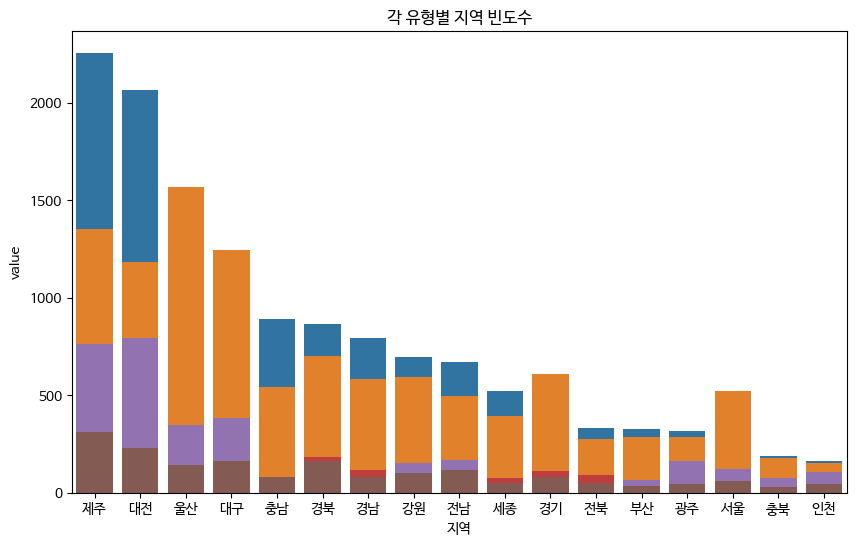

In [109]:
# 그래프 합쳐서 나타내고 싶었는데 4개씩까지밖에 안나오는듯
plt.figure(figsize=(10, 6))
sns.barplot(data = df_nature, x="지역", y="value")
sns.barplot(data = df_culture, x="지역", y="value")
sns.barplot(data = df_leisure, x="지역", y="value")
sns.barplot(data = df_history, x="지역", y="value")
sns.barplot(data = df_food, x="지역", y="value")
sns.barplot(data = df_healing, x="지역", y="value")

plt.title('각 유형별 지역 빈도수')
plt.show()

<Axes: xlabel='지역', ylabel='value'>

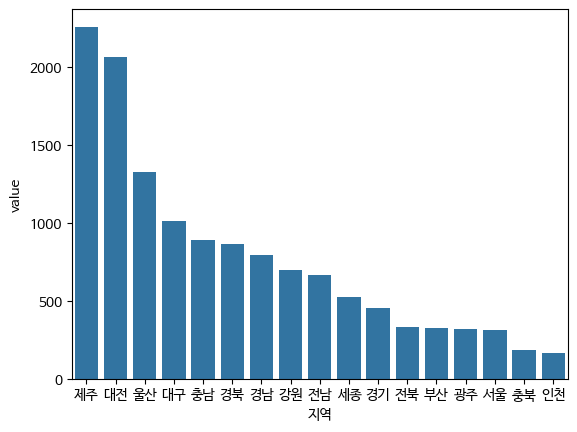

In [110]:
sns.barplot(data = df_nature.sort_values(by = "value", ascending = False), x="지역", y="value")

<Axes: xlabel='지역', ylabel='value'>

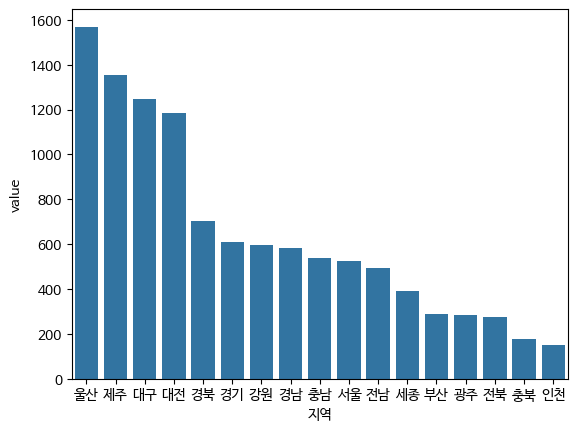

In [111]:
sns.barplot(data = df_culture.sort_values(by = "value", ascending = False), x="지역", y="value")

<Axes: xlabel='지역', ylabel='value'>

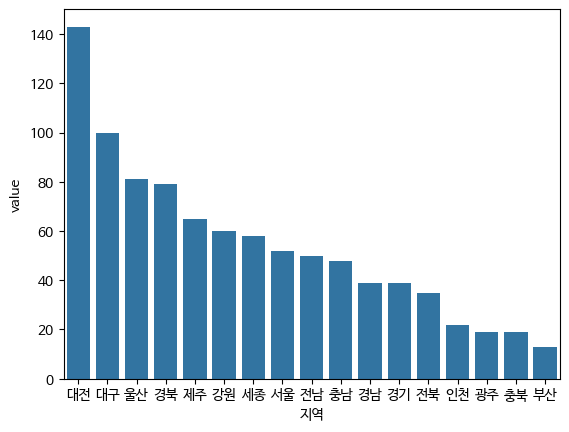

In [112]:
sns.barplot(data = df_leisure.sort_values(by = "value", ascending = False), x="지역", y="value")

<Axes: xlabel='지역', ylabel='value'>

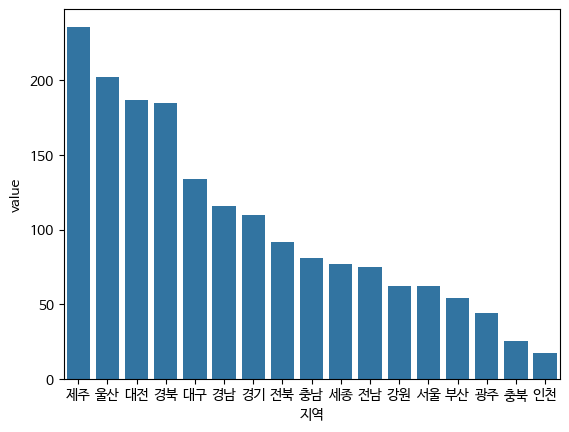

In [113]:
sns.barplot(data = df_history.sort_values(by = "value", ascending = False), x="지역", y="value")

<Axes: xlabel='지역', ylabel='value'>

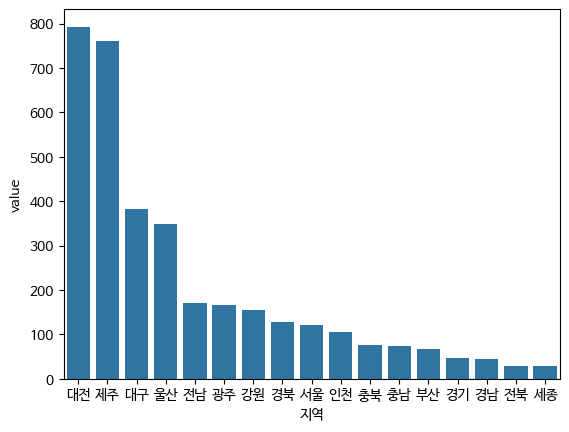

In [114]:
sns.barplot(data = df_food.sort_values(by = "value", ascending = False), x="지역", y="value")

<Axes: xlabel='지역', ylabel='value'>

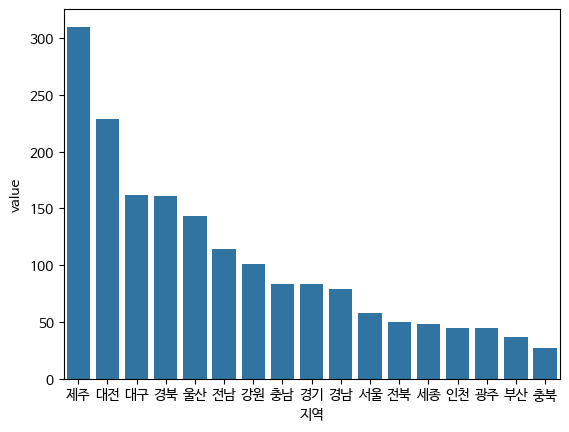

In [115]:
sns.barplot(data = df_healing.sort_values(by = "value", ascending = False), x="지역", y="value")

#### (2) 접근 2 :계절빈도 수
- 결과
  + 자연 : 가을 > 봄 > 여름 > 겨울
  + 문화 : 겨울 > 가을 > 여름 > 봄
  + 레져 : 가을 > 여름 > 겨울 > 봄
  + 역사 : 겨울 > 가을 > 봄 = 여름
  + 음식 : 겨울 > 여름 > 가을 > 봄
  + 힐링 : 가을 > 여름 > 겨울 > 봄

In [116]:
nature_1_spring = df_tour_concept.query("concept_name == '자연'").query("season =='1'").value_counts().sum()
nature_2_summer = df_tour_concept.query("concept_name == '자연'").query("season =='2'").value_counts().sum()
nature_3_autumn = df_tour_concept.query("concept_name == '자연'").query("season =='3'").value_counts().sum()
nature_4_winter = df_tour_concept.query("concept_name == '자연'").query("season =='4'").value_counts().sum()

df_nature_weather = pd.DataFrame({'계절' : ["봄","여름","가을","겨울"], 'value': [nature_1_spring, nature_2_summer, nature_3_autumn, nature_4_winter]})
df_nature_weather

,계절,value
0,봄,1170
1,여름,599
2,가을,1314
3,겨울,578


In [117]:
culture_1_spring = df_tour_concept.query("concept_name == '문화'").query("season =='1'").value_counts().sum()
culture_2_summer = df_tour_concept.query("concept_name == '문화'").query("season =='2'").value_counts().sum()
culture_3_autumn = df_tour_concept.query("concept_name == '문화'").query("season =='3'").value_counts().sum()
culture_4_winter = df_tour_concept.query("concept_name == '문화'").query("season =='4'").value_counts().sum()

df_culture_weather = pd.DataFrame({'계절' : ["봄","여름","가을","겨울"], 'value': [culture_1_spring, culture_2_summer, culture_3_autumn, culture_4_winter]})
df_culture_weather

,계절,value
0,봄,168
1,여름,255
2,가을,313
3,겨울,336


In [118]:
leisure_1_spring = df_tour_concept.query("concept_name == '레져'").query("season =='1'").value_counts().sum()
leisure_2_summer = df_tour_concept.query("concept_name == '레져'").query("season =='2'").value_counts().sum()
leisure_3_autumn = df_tour_concept.query("concept_name == '레져'").query("season =='3'").value_counts().sum()
leisure_4_winter = df_tour_concept.query("concept_name == '레져'").query("season =='4'").value_counts().sum()

df_leisure_weather = pd.DataFrame({'계절' : ["봄","여름","가을","겨울"], 'value': [leisure_1_spring, leisure_2_summer, leisure_3_autumn, leisure_4_winter]})
df_leisure_weather

,계절,value
0,봄,29
1,여름,42
2,가을,82
3,겨울,38


In [119]:
history_1_spring = df_tour_concept.query("concept_name == '역사'").query("season =='1'").value_counts().sum()
history_2_summer = df_tour_concept.query("concept_name == '역사'").query("season =='2'").value_counts().sum()
history_3_autumn = df_tour_concept.query("concept_name == '역사'").query("season =='3'").value_counts().sum()
history_4_winter = df_tour_concept.query("concept_name == '역사'").query("season =='4'").value_counts().sum()

df_leisure_weather = pd.DataFrame({'계절' : ["봄","여름","가을","겨울"], 'value': [history_1_spring, history_2_summer, history_3_autumn, history_4_winter]})
df_leisure_weather

,계절,value
0,봄,19
1,여름,19
2,가을,18
3,겨울,23


In [120]:
food_1_spring = df_tour_concept.query("concept_name == '음식'").query("season =='1'").value_counts().sum()
food_2_summer = df_tour_concept.query("concept_name == '음식'").query("season =='2'").value_counts().sum()
food_3_autumn = df_tour_concept.query("concept_name == '음식'").query("season =='3'").value_counts().sum()
food_4_winter = df_tour_concept.query("concept_name == '음식'").query("season =='4'").value_counts().sum()

df_leisure_weather = pd.DataFrame({'계절' : ["봄","여름","가을","겨울"], 'value': [food_1_spring, food_2_summer, food_3_autumn, food_4_winter]})
df_leisure_weather

,계절,value
0,봄,28
1,여름,84
2,가을,52
3,겨울,89


In [121]:
healing_1_spring = df_tour_concept.query("concept_name == '힐링'").query("season =='1'").value_counts().sum()
healing_2_summer = df_tour_concept.query("concept_name == '힐링'").query("season =='2'").value_counts().sum()
healing_3_autumn = df_tour_concept.query("concept_name == '힐링'").query("season =='3'").value_counts().sum()
healing_4_winter = df_tour_concept.query("concept_name == '힐링'").query("season =='4'").value_counts().sum()

df_leisure_weather = pd.DataFrame({'계절' : ["봄","여름","가을","겨울"], 'value': [healing_1_spring, healing_2_summer, healing_3_autumn,healing_4_winter]})
df_leisure_weather

,계절,value
0,봄,39
1,여름,117
2,가을,124
3,겨울,48


## 결론

- 지역별
  + 계절 : 1순위로 가을이 가장 많았으며 예외로 강원에서는 겨울이 1위였음. 2순위에서는 지역마다 봄 또는 겨울이 자주 나왔으며 여름이 후순위에 있는 것은 의외라고 생각.
  + 여행유형 : 1,2순위는 대체적으로 자연,문화 값이 나옴. 3순위는 음식이나 역사가 주로 나왔다. => 지역 선택시 여행 유형을 추천해줄때 자연,문화 컨셉을 주로 추천하고 추가적인 정보를 원할때 후순위에 해당하는 유형추천
- 계절별
  + 지역 : 제주, 대전이 많았음. 겨울에 강원의 빈도 수가 올라오는 것을 확인할 수 있음, 연관x
  + 여행유형 :  대체적으로 1,2순위는 자연,문화 값이 나옴. 연관 x
- 유형별
  + 지역 : 대체적으로 제주,대전,울산이 빈도수가 높았음. 연관 x
  + 계절 :
      + 자연 유형은 대체적으로 날이 날씨가 화창하거나 선선할때(가을,봄) 빈도수가 높았음
      + 대체적으로 봄의 빈도가 낮았음.
  